## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time
import copy


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)


In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break


torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [0]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # nn.Conv2d(in_channels=1, out_channels=input_shape, kernel_size=3),
            nn.Linear(input_shape, input_shape),
            nn.BatchNorm1d(input_shape),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(input_shape, num_classes),
            # nn.ReLU()
        )
        
    def forward(self, inp):       
        return self.model(inp)
        # out = nn.Flatten(inp)
        # print(out)


In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
       BatchNorm1d-3                  [-1, 784]           1,568
              ReLU-4                  [-1, 784]               0
           Dropout-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
Total params: 624,858
Trainable params: 624,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.38
Estimated Total Size (MB): 2.42
----------------------------------------------------------------


Your experiments come here:

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    # best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model.forward(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model.forward(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'train' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # best_model_wts = copy.deepcopy(model.state_dict())
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # print(train_loss_history)
    # print(val_loss_history)

    plt.title('Loss')
    plt.xlabel('Iteration')
    plt.ylabel('loss')
    plt.plot(train_loss_history)
    plt.plot(val_loss_history)
    plt.legend(['Train', "Val"])
    plt.show()

    plt.title('Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('acc')
    plt.plot(train_acc_history)
    plt.plot(val_acc_history)
    plt.legend(['Train', "Val"])
    plt.show()

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

Epoch 0/24
----------
train Loss: 0.6080 Acc: 0.7945
val Loss: 0.4542 Acc: 0.8418

Epoch 1/24
----------
train Loss: 0.4213 Acc: 0.8523
val Loss: 0.4074 Acc: 0.8572

Epoch 2/24
----------
train Loss: 0.3835 Acc: 0.8641
val Loss: 0.3801 Acc: 0.8623

Epoch 3/24
----------
train Loss: 0.3577 Acc: 0.8730
val Loss: 0.3657 Acc: 0.8677

Epoch 4/24
----------
train Loss: 0.3392 Acc: 0.8790
val Loss: 0.3609 Acc: 0.8716

Epoch 5/24
----------
train Loss: 0.3235 Acc: 0.8846
val Loss: 0.3431 Acc: 0.8768

Epoch 6/24
----------
train Loss: 0.3113 Acc: 0.8891
val Loss: 0.3392 Acc: 0.8789

Epoch 7/24
----------
train Loss: 0.3022 Acc: 0.8921
val Loss: 0.3399 Acc: 0.8765

Epoch 8/24
----------
train Loss: 0.2924 Acc: 0.8952
val Loss: 0.3360 Acc: 0.8769

Epoch 9/24
----------
train Loss: 0.2845 Acc: 0.8978
val Loss: 0.3251 Acc: 0.8831

Epoch 10/24
----------
train Loss: 0.2749 Acc: 0.9014
val Loss: 0.3204 Acc: 0.8852

Epoch 11/24
----------
train Loss: 0.2682 Acc: 0.9032
val Loss: 0.3176 Acc: 0.8862

Ep

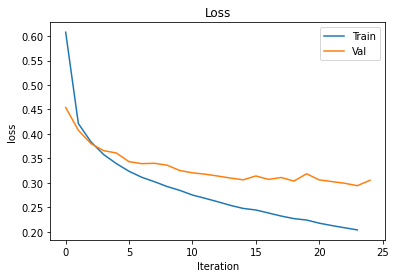

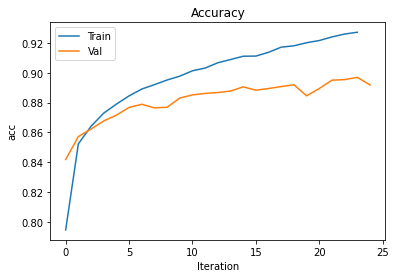

In [10]:
model = TinyNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

result = train_model(model, {'train': train_loader, 'val': test_loader}, criterion, optimizer)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [0]:
from copy import copy

fmnist_dataset_train_small = copy(fmnist_dataset_train)
fmnist_dataset_train_small.data = fmnist_dataset_train.data[:900]
fmnist_dataset_train_small.targets = fmnist_dataset_train.targets[:900]

train_loader_small = torch.utils.data.DataLoader(fmnist_dataset_train_small, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

fmnist_dataset_test_small = copy(fmnist_dataset_test)
fmnist_dataset_test_small.data = fmnist_dataset_test.data[:900]
fmnist_dataset_test_small.targets = fmnist_dataset_test.targets[:900]

test_loader_small = torch.utils.data.DataLoader(fmnist_dataset_test_small, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [0]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        # self.model = nn.Sequential(
            # nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # # nn.Conv2d(in_channels=1, out_channels=input_shape, kernel_size=3),
            # nn.Linear(input_shape, input_shape),
            # nn.ReLU(),
            # nn.Linear(input_shape, num_classes),



            # nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, stride = 1, padding = 2),
            # nn.ReLU(),
            # # nn.BatchNorm2d(32),
            # # nn.MaxPool2d(kernel_size=2),
            # nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 2),
            # nn.ReLU(),
            # # nn.BatchNorm2d(64),
            # # nn.MaxPool2d(kernel_size=2),
            # nn.Linear(4096, 4096),
            # nn.ReLU(),
            # nn.Linear(4096, 10)
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
        self.relu1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(32)
        nn.init.xavier_uniform(self.cnn1.weight)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 2)
        self.relu2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(64)
        nn.init.xavier_uniform(self.cnn2.weight)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(4096, 4096)
        self.fcrelu = nn.ReLU()

        self.fc2 = nn.Linear(4096, 4096)
        self.fcrelu = nn.ReLU()

        self.fc3 = nn.Linear(4096, 10)
        # )
        
    def forward(self, inp): 
        # print(inp.shape) 
        out = self.cnn1(inp)
        out = self.relu1(out)
        # out = self.norm1(out)

        out = self.maxpool1(out)

        out = self.cnn2(out)
        out = self.relu2(out)
        # out = self.norm2(out)

        out = self.maxpool2(out)

        out = out.view(out.size(0),-1)

        out = self.fc1(out)
        out = self.fcrelu(out)

        out = self.fc2(out)
        out = self.fcrelu(out)

        out = self.fc3(out)
        return out


In [0]:
# torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch 0/99
----------
train Loss: 2.2406 Acc: 0.2578
val Loss: 2.0971 Acc: 0.5167

Epoch 1/99
----------
train Loss: 1.9664 Acc: 0.3900
val Loss: 1.7136 Acc: 0.4833

Epoch 2/99
----------
train Loss: 1.5615 Acc: 0.5222
val Loss: 1.3398 Acc: 0.5367

Epoch 3/99
----------
train Loss: 1.2618 Acc: 0.5200
val Loss: 1.1162 Acc: 0.6078

Epoch 4/99
----------
train Loss: 1.1017 Acc: 0.6100
val Loss: 1.0762 Acc: 0.5433

Epoch 5/99
----------
train Loss: 1.0314 Acc: 0.5922
val Loss: 0.9153 Acc: 0.6211

Epoch 6/99
----------
train Loss: 0.9320 Acc: 0.6322
val Loss: 0.8756 Acc: 0.6244

Epoch 7/99
----------
train Loss: 0.8760 Acc: 0.6511
val Loss: 0.8090 Acc: 0.6889

Epoch 8/99
----------
train Loss: 0.7853 Acc: 0.7078
val Loss: 0.8167 Acc: 0.6522

Epoch 9/99
----------
train Loss: 0.7705 Acc: 0.7111
val Loss: 0.7429 Acc: 0.6989

Epoch 10/99
----------
train Loss: 0.7068 Acc: 0.7222
val Loss: 0.7118 Acc: 0.7356

Epoch 11/99
----------
train Loss: 0.7432 Acc: 0.7044
val Loss: 0.7374 Acc: 0.7011

Ep

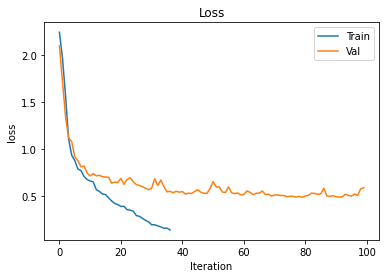

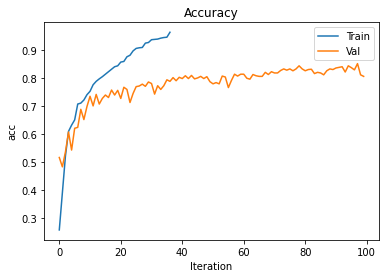

In [24]:
model = OverfittingNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

result = train_model(model, {'train': train_loader_small, 'val': test_loader_small}, criterion, optimizer, num_epochs=100)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [0]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, stride = 1, padding = 2)
        self.relu1 = nn.ReLU()
        self.norm1 = nn.BatchNorm2d(32)
        nn.init.xavier_uniform(self.cnn1.weight)

        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 2)
        self.relu2 = nn.ReLU()
        self.norm2 = nn.BatchNorm2d(64)
        nn.init.xavier_uniform(self.cnn2.weight)

        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(4096, 4096)
        self.fcrelu = nn.ReLU()

        self.fc2 = nn.Linear(4096, 10)
        # )
        
    def forward(self, inp): 
        # print(inp.shape) 
        out = self.cnn1(inp)
        out = nn.Dropout()(out)
        out = self.relu1(out)
        out = self.norm1(out)

        out = self.maxpool1(out)

        out = self.cnn2(out)
        out = nn.Dropout()(out)
        out = self.relu2(out)
        out = self.norm2(out)

        out = self.maxpool2(out)

        out = out.view(out.size(0),-1)

        out = self.fc1(out)
        out = self.fcrelu(out)

        out = self.fc2(out)
        return out

In [0]:
# torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


train Loss: 0.4750 Acc: 0.8280
val Loss: 0.4052 Acc: 0.8571

Epoch 1/24
----------
train Loss: 0.3435 Acc: 0.8730
val Loss: 0.3505 Acc: 0.8716

Epoch 2/24
----------
train Loss: 0.3076 Acc: 0.8847
val Loss: 0.3225 Acc: 0.8815

Epoch 3/24
----------
train Loss: 0.2804 Acc: 0.8961
val Loss: 0.3190 Acc: 0.8808

Epoch 4/24
----------
train Loss: 0.2558 Acc: 0.9050
val Loss: 0.2869 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.2387 Acc: 0.9099
val Loss: 0.2863 Acc: 0.8927

Epoch 6/24
----------
train Loss: 0.2256 Acc: 0.9159
val Loss: 0.2762 Acc: 0.9010

Epoch 7/24
----------
train Loss: 0.2124 Acc: 0.9194
val Loss: 0.2681 Acc: 0.9006

Epoch 8/24
----------
train Loss: 0.2002 Acc: 0.9238
val Loss: 0.2714 Acc: 0.9036

Epoch 9/24
----------
train Loss: 0.1892 Acc: 0.9277
val Loss: 0.2643 Acc: 0.9048

Epoch 10/24
----------
train Loss: 0.1767 Acc: 0.9337
val Loss: 0.2662 Acc: 0.9069

Epoch 11/24
----------
train Loss: 0.1705 Acc: 0.9346
val Loss: 0.2522 Acc: 0.9067

Epoch 12/24
----------
t

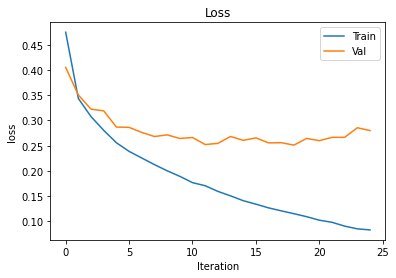

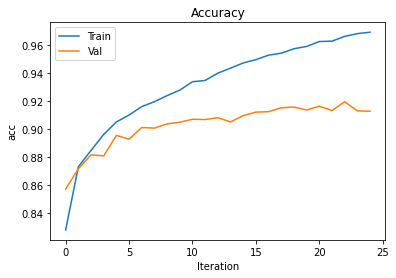

(FixedNeuralNetwork(
   (cnn1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (relu1): ReLU()
   (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
   (relu2): ReLU()
   (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=4096, out_features=4096, bias=True)
   (fcrelu): ReLU()
   (fc2): Linear(in_features=4096, out_features=10, bias=True)
 ),
 [tensor(0.8280, device='cuda:0', dtype=torch.float64),
  tensor(0.8730, device='cuda:0', dtype=torch.float64),
  tensor(0.8847, device='cuda:0', dtype=torch.float64),
  tensor(0.8961, device='cuda:0', dtype=torch.float64),
  tensor(0.9050, device='cuda:0', dtype=torch.fl

In [25]:
model = FixedNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_model(model, {'train': train_loader, 'val': test_loader}, criterion, optimizer, num_epochs=25)

### Conclusions:
Оферфитинг - очень опасная штука, которая может неверно исказить работоспособность модели. Оказывается как никогда актуальной бритва Окама - чем меньше слоёв тем лучше. Поэтому не стоит строить сложные решения, пока не опробуешь простые. Так же Dropout и Batchnorm помогают.